In [1]:
import torch
import numpy as np
import h5py
from matplotlib import pyplot as plt
import seaborn as sns

# Top Quark Tagging using LSTM

The top quark tagging algorithm is trained to classify top quarks from light-flavor quarks using simulated events
generated at $\sqrt{s}$  = 13 TeV for comparison to LHC performance. 

Require latencies of less than approximately a few microseconds in order to fit within experimental constraints.

The transverse momenta (pT) of the partons are generated in a window with energy spread given by $\frac{\delta{p_T}}{P_T} = 0.01$, centered at 1 TeV. Particles inside a jet are ordered according to their $P_T$ and up to 30 particles are used in
this study. 

For each particle **15 features are used**: 
- $P_T$
- pseudorapidity ($\eta$)
- azimuthal angle ($\phi$)
- energy
- relative angular distance from the jet axis
- ....
   

# Create Dataset

Only low level features are used in this study. Particles inside a jet are
ordered according to their pT and up to 30 particles are used in this study.

In [4]:
# Create a function that generates the file name to access the data
# Should be in the format: jetImage_N_30p_START_STOP.h5
# N goes from 0 to 6 and START and STOP are the start and stop indices of the data which increment by 10000

def get_file_name(N, start, stop):
    return f"data/train/jetImage_{N}_30p_{start}_{stop}.h5"

In [3]:
def h5_tree(val, pre='', out=""):
    length = len(val)
    for key, val in val.items():
        length -= 1
        if length == 0:  # the last item
            if type(val) == h5py._hl.group.Group:
                out += pre + '└── ' + key + "\n"
                out = h5_tree(val, pre+'    ', out)
            else:
                out += pre + '└── ' + key + f' {val.shape}\n'
        else:
            if type(val) == h5py._hl.group.Group:
                out += pre + '├── ' + key + "\n"
                out = h5_tree(val, pre+'│   ', out)
            else:
                out += pre + '├── ' + key + f' {val.shape}\n'
    return out

filename = get_file_name(0, 0, 10000)

with h5py.File(filename, "r") as file:
    structure = h5_tree(file)
    print(structure)

├── jetConstituentList (10000, 30, 16)
├── jetFeatureNames (59,)
├── jetImage (10000, 100, 100)
├── jetImageECAL (10000, 100, 100)
├── jetImageHCAL (10000, 100, 100)
├── jets (10000, 59)
└── particleFeatureNames (17,)



In [2]:
# open a h5 file in this location data\train\jetImage_0_30p_0_10000.h5

with h5py.File('data/train/jetImage_0_30p_0_10000.h5', 'r') as f:
    # copy data to numpy array
    ConstituentList = np.array(f['jetConstituentList'])
    jetFeatureNames = np.array(f['jetFeatureNames'])
    Image = np.array(f['jetImage'])
    ImageECAL = np.array(f['jetImageECAL'])
    ImageHCAL = np.array(f['jetImageHCAL'])
    jets = np.array(f['jets'])
    particleFeatureNames = np.array(f['particleFeatureNames'])


Apparently whether or not the jet is a top quark is given by the value of the jets[-2], judging by the jetFeatureNames[-2] wich is j_t

In [10]:
print(jetFeatureNames[-2], "\n")

for i in range(10):
    print(jets[i][-2])

b'j_t' 

0.0
0.0
1.0
0.0
0.0
0.0
1.0
0.0
0.0
0.0


Each jet has constituents particles given by ConstituentList and the features of that list is given by particleFeatureNames (its +1 why?)

In [11]:
print("Constituents of the jet array shape: ", ConstituentList.shape)

print("Feature names of the constituents array shape: ", particleFeatureNames.shape)

print("Actual Feature names: ", particleFeatureNames)

Constituents of the jet array shape:  (10000, 30, 16)
Feature names of the constituents array shape:  (17,)
Actual Feature names:  [b'j1_px' b'j1_py' b'j1_pz' b'j1_e' b'j1_erel' b'j1_pt' b'j1_ptrel'
 b'j1_eta' b'j1_etarel' b'j1_etarot' b'j1_phi' b'j1_phirel' b'j1_phirot'
 b'j1_deltaR' b'j1_costheta' b'j1_costhetarel' b'j1_pdgid']


In [9]:
print("Pt is feature number 5: ", particleFeatureNames[5])

print("Eta is feature number 7: ", particleFeatureNames[7])

print("Phi is feature number 9: ", particleFeatureNames[9])

print("Energy is feature number 3: ", particleFeatureNames[3])

print("Relative angular distance form the jet axis is feature number 15: ", particleFeatureNames[15])

print("Particle ID is feature number 16: ", particleFeatureNames[16])

Pt is feature number 5:  b'j1_pt'
Eta is feature number 7:  b'j1_eta'
Phi is feature number 9:  b'j1_etarot'
Energy is feature number 3:  b'j1_e'
Relative angular distance form the jet axis is feature number 15:  b'j1_costhetarel'
Particle ID is feature number 16:  b'j1_pdgid'


## Order the particles by $P_T$

In [12]:
sort_idx = np.argsort(-ConstituentList[:, :, 5], axis=1)
sorted_by_Pt_ConstituentList = np.take_along_axis(ConstituentList, sort_idx[:, :, None], axis=1)

## Pick the first 30 particles

In [13]:
sorted_by_Pt_ConstituentList = sorted_by_Pt_ConstituentList[:, :30, :]
sorted_by_Pt_ConstituentList.shape

(10000, 30, 16)

### Check

In [14]:
print(sorted_by_Pt_ConstituentList.shape)
print(sorted_by_Pt_ConstituentList[0, :, 5]) #energy feature

(10000, 30, 16)
[403.6696167  137.84762573  55.31867599  51.98291016  46.44296265
  44.40916443  35.66338348  34.52863693  26.9210701   26.68380737
  25.1668129   24.71984291  23.69188499  18.91986275  17.34101677
  16.06336594  15.03250504  13.56627464  13.05364704  12.29211807
  11.66733074  10.30390549  10.0585041    9.32068253   9.16318035
   8.45135498   7.36849403   6.6919632    6.24873447   5.24096203]


In [16]:
print(sorted_by_Pt_ConstituentList.shape)
feature_tensor = torch.from_numpy(sorted_by_Pt_ConstituentList).float()

(10000, 30, 16)


## Keep the labels array

In [17]:
print(jets[:, -2].shape)
label_tensor = torch.from_numpy(jets[:, -2]).float()

(10000,)


## Ready to convert to a pytorch dataset and save

In [18]:
torch.save({
    'features': feature_tensor,
    'labels': label_tensor
}, 'tt_dataset.pt')

## Load the Dataset

In [5]:
# Open file, manipulate data, and concatenate to a single tensor
# for all files in the directory
features=torch.from_numpy(np.array([]))
labels=torch.from_numpy(np.array([]))
for i in [0,1,2,3,4,5,6]:
    for j in range(0, 90000, 10000):
        if (j==30000) & (i!=2):
            filename = get_file_name(i, j, j + 10000)
            with h5py.File(filename, 'r') as f:
                # copy data to numpy array
                ConstituentList = np.array(f['jetConstituentList'])
                jet_feats = np.array(f['jets'])
            # sort the constituents by pt
            sort_idx = np.argsort(-ConstituentList[:, :, 5], axis=1)
            sorted_by_Pt_ConstituentList = np.take_along_axis(ConstituentList, sort_idx[:, :, None], axis=1)
            # take the first 30 constituents
            sorted_by_Pt_ConstituentList = sorted_by_Pt_ConstituentList[:, :30, :]
            # take the features we want (exclude particles id)
            sorted_by_Pt_ConstituentList = sorted_by_Pt_ConstituentList[:, :,:-1]
            # convert to torch tensor
            feature_tensor = torch.from_numpy(sorted_by_Pt_ConstituentList).float()
            label_tensor = torch.from_numpy(jet_feats[:, -2]).float()
            # concatenate to a tensor
            if i == 0 and j == 0:
                features = feature_tensor
                labels = label_tensor
            else:
                features = torch.cat((features, feature_tensor), dim=0)
                labels = torch.cat((labels, label_tensor), dim=0)
    print(f"Saved file {i} with shape {features.shape} and {labels.shape}")
    # save the tensor to a file
    torch.save({
        'features': features,
        'labels': labels}, f"tt_train_dataset_{i}.pt")


Saved file 0 with shape torch.Size([10000, 30, 15]) and torch.Size([10000])
Saved file 1 with shape torch.Size([20000, 30, 15]) and torch.Size([20000])
Saved file 2 with shape torch.Size([20000, 30, 15]) and torch.Size([20000])
Saved file 3 with shape torch.Size([30000, 30, 15]) and torch.Size([30000])
Saved file 4 with shape torch.Size([40000, 30, 15]) and torch.Size([40000])
Saved file 5 with shape torch.Size([50000, 30, 15]) and torch.Size([50000])
Saved file 6 with shape torch.Size([60000, 30, 15]) and torch.Size([60000])


In [2]:
# Check if file i contains also data from file i-1

datasets = [torch.load(f'tt_train_dataset_{i}.pt') for i in range(7)]
features_list = [ds['features'] for ds in datasets]
labels_list = [ds['labels'] for ds in datasets]

for i in range(1, 7):
    prev_feats = features_list[i-1]
    curr_feats = features_list[i]
    
    n = prev_feats.shape[0]
    match = torch.allclose(curr_feats[:n], prev_feats)
    
    print(f"File {i} contains file {i-1}? {'Yes' if match else 'No'}")


/tmp/ipykernel_22014/469067167.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  datasets = [torch.load(f'tt_train_dataset_{i}.pt') for i in range(7)]


File 1 contains file 0? Yes
File 2 contains file 1? Yes
File 3 contains file 2? Yes
File 4 contains file 3? Yes
File 5 contains file 4? Yes
File 6 contains file 5? Yes


Then we can just use data from file 6 for the training

## Features visualization

/tmp/ipykernel_32096/3996628977.py:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(f'tt_train_dataset_6.pt')


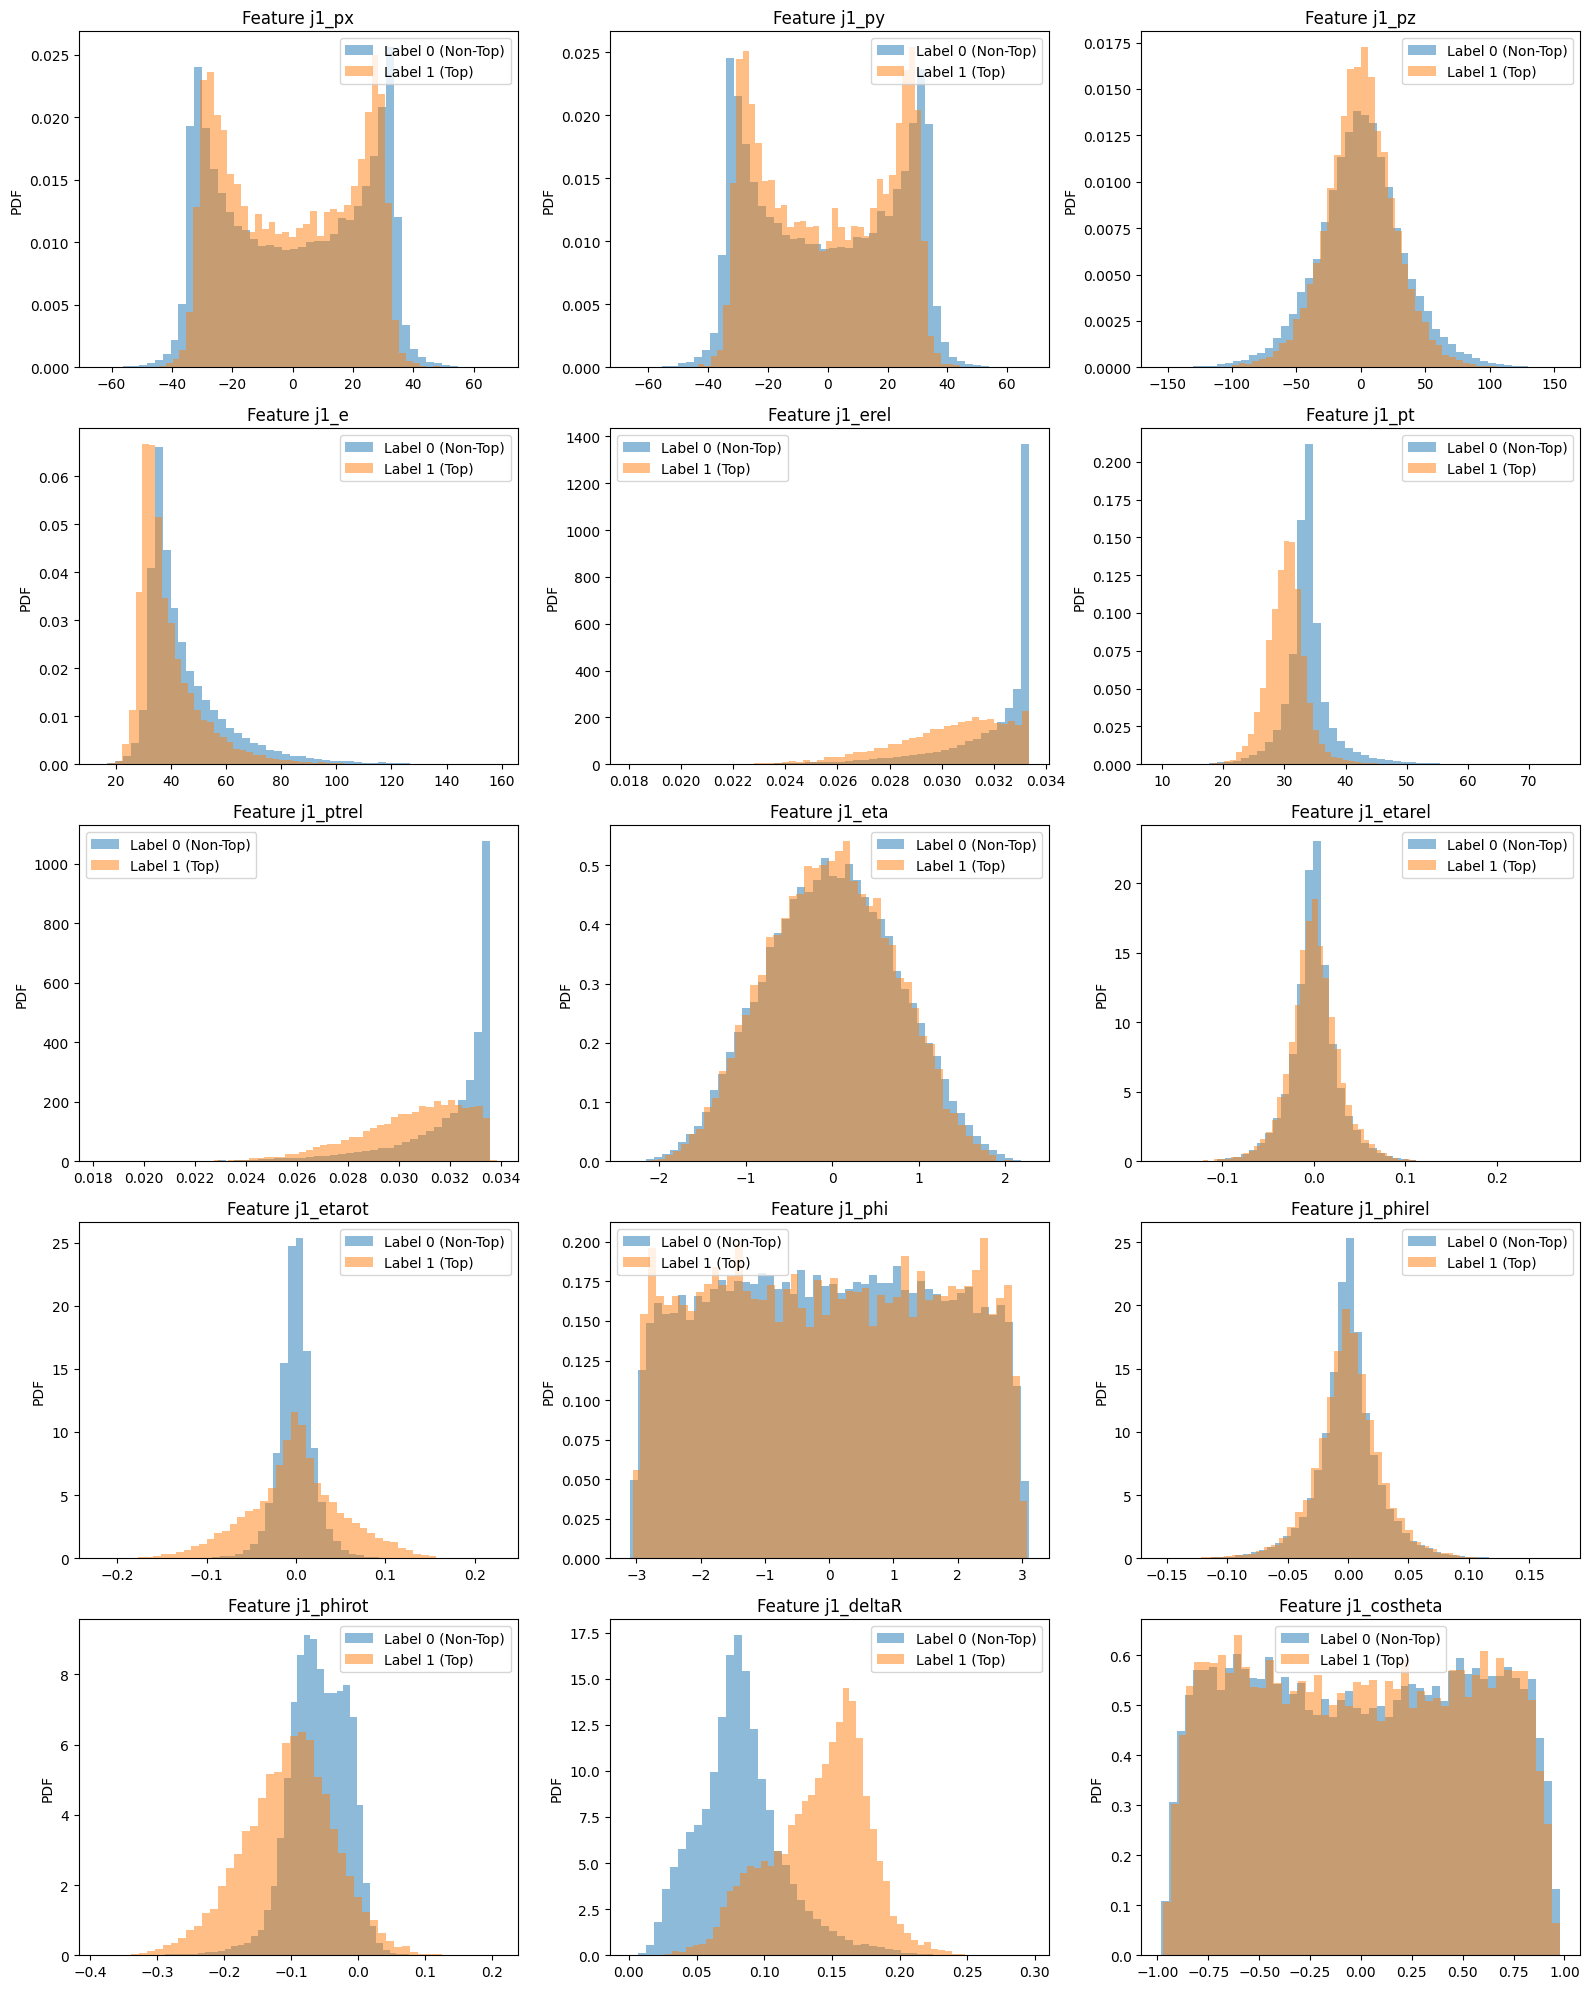

In [10]:
# using mean values of the features over the 30 particles 
data_dict = torch.load(f'tt_train_dataset_6.pt')
features= data_dict['features']  # shape: [N, 30, 15]
labels = data_dict['labels']   
features = features.mean(dim=1)  # mean of each feature over the 30 particles; now shape is [N, 15] 
features_np = features.numpy()
labels_np = labels.numpy()
particleFeatureNames = [name.decode('utf-8') if isinstance(name, bytes) else name for name in particleFeatureNames] # convert byte to strings

# histograms of the features divided per label 
num_features = features_np.shape[1]
fig, axes = plt.subplots(5, 3, figsize=(16, 20))
axes = axes.flatten()

for i in range(num_features):
    ax = axes[i]
    ax.hist(features_np[labels_np == 0][:, i], bins=50, alpha=0.5, label='Label 0 (Non-Top)', density=True)
    ax.hist(features_np[labels_np == 1][:, i], bins=50, alpha=0.5, label='Label 1 (Top)', density=True)
    ax.set_title(f'Feature {particleFeatureNames[i]}')
    ax.set_ylabel('PDF')
    ax.legend()
plt.tight_layout()
plt.show()

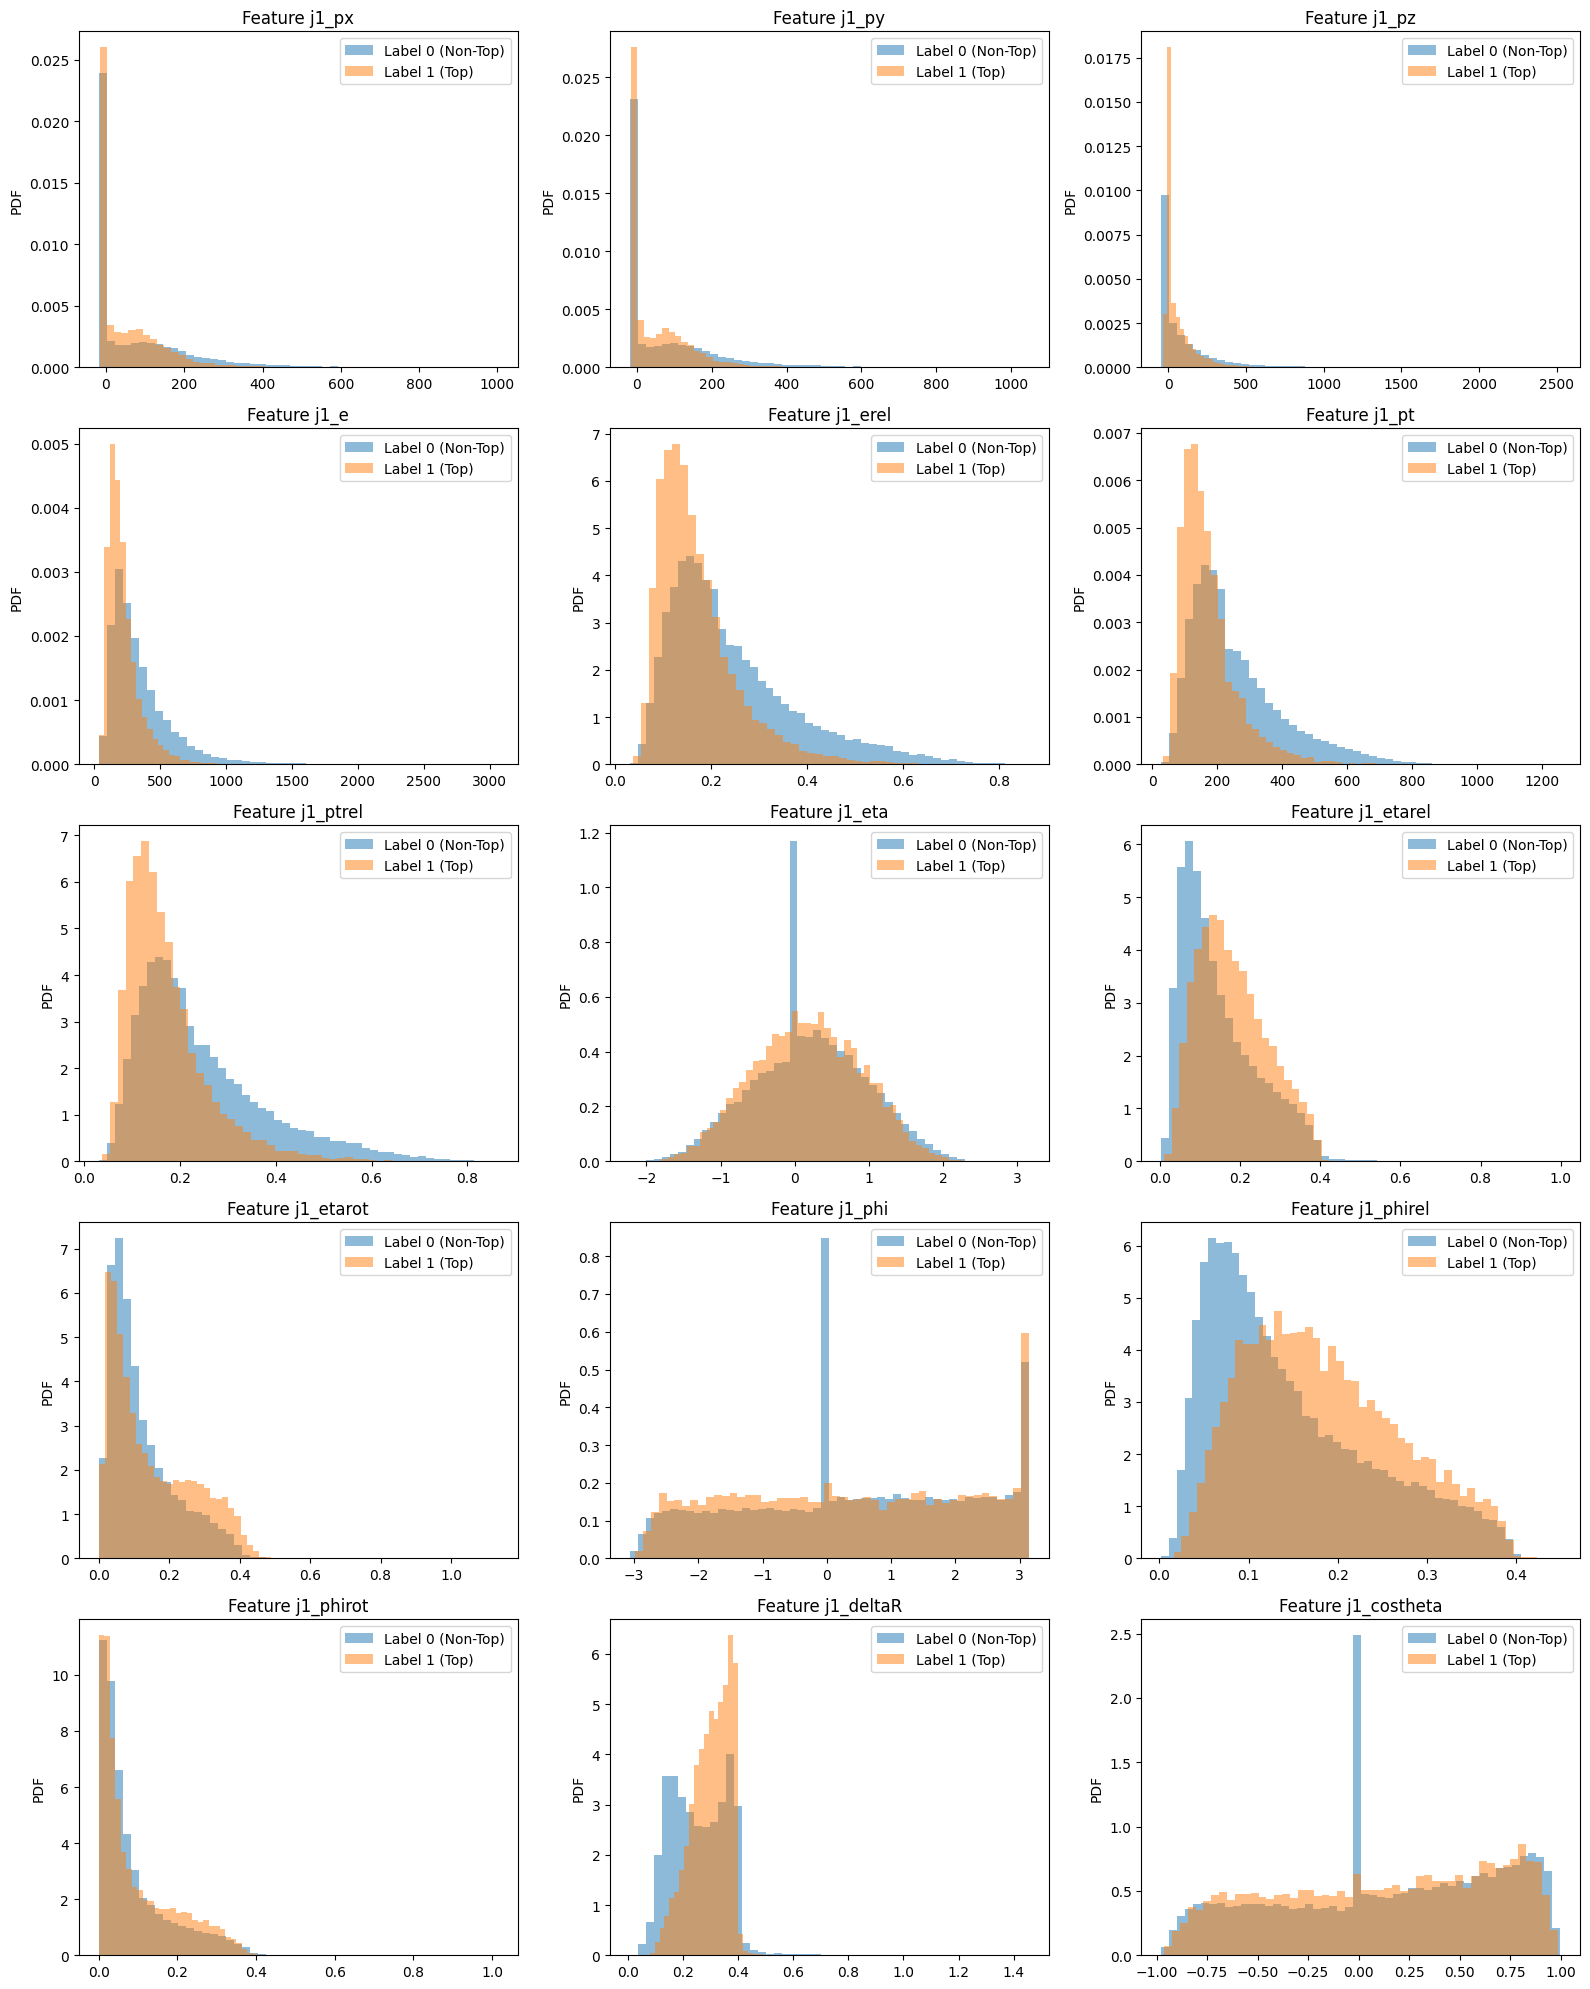

In [16]:
# using max values of the features over the 30 particles

features= data_dict['features']
features = features.max(dim=1).values.numpy()  # max of each feature over the 30 particles; now shape is [N, 15] 

fig, axes = plt.subplots(5, 3, figsize=(16, 20))
axes = axes.flatten()
for i in range(num_features):
    ax = axes[i]
    ax.hist(features[labels_np == 0][:, i], bins=50, alpha=0.5, label='Label 0 (Non-Top)', density=True)
    ax.hist(features[labels_np == 1][:, i], bins=50, alpha=0.5, label='Label 1 (Top)', density=True)
    ax.set_title(f'Feature {particleFeatureNames[i]}')
    ax.set_ylabel('PDF')
    ax.legend()
plt.tight_layout()
plt.show()

## Study of the correlation between features and labels

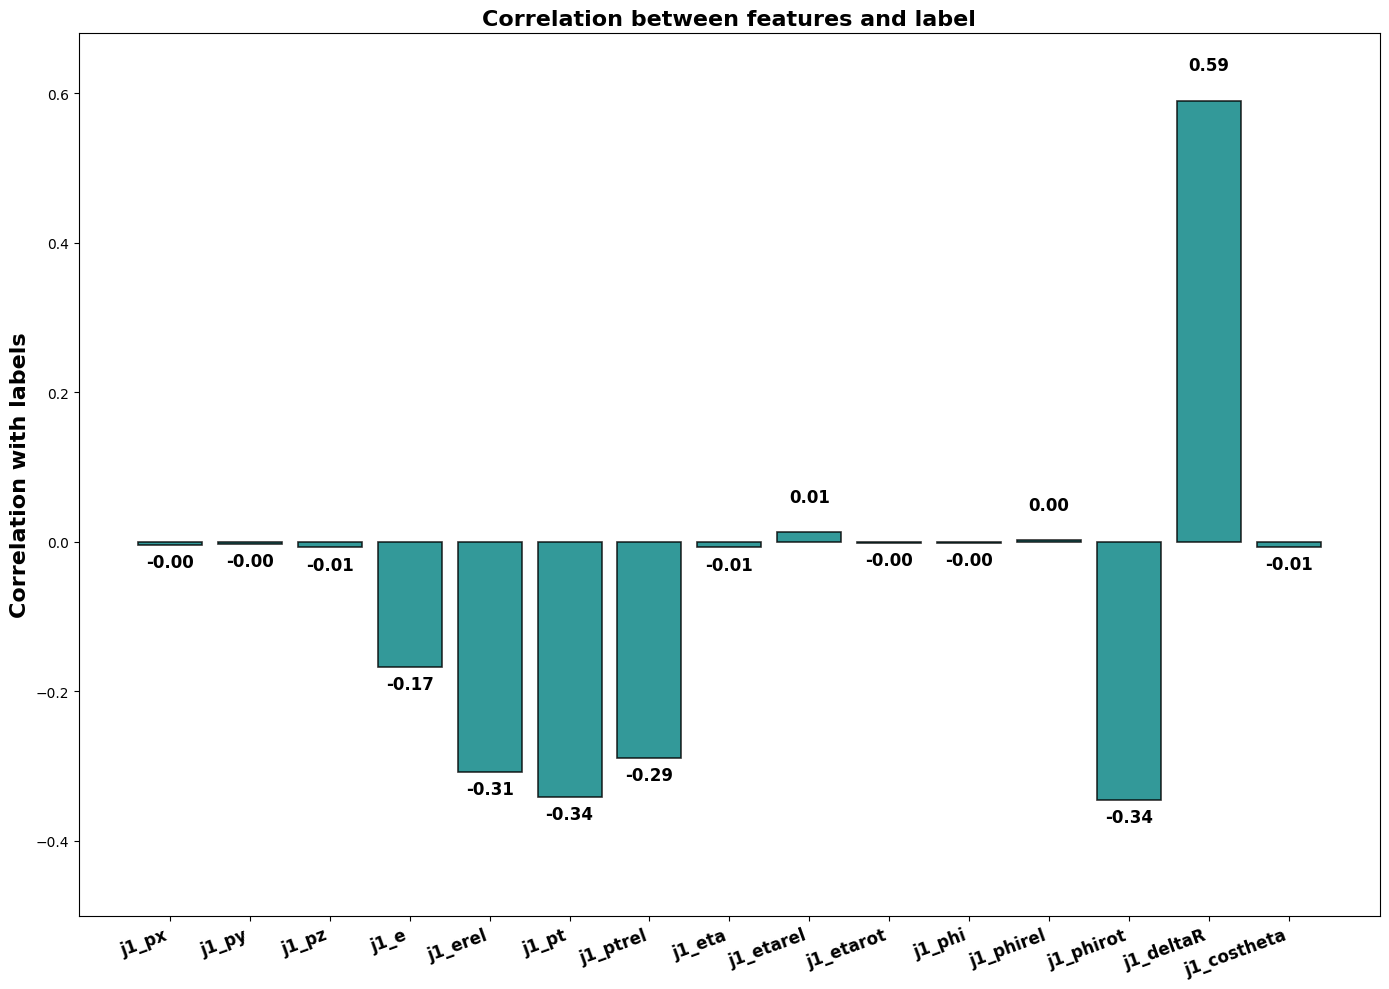

In [39]:
# we use Pearson's coefficient to analyze the correlation between the mean value over the 30 particles for each feature and the correspondent label 

features= data_dict['features']  # shape: [N, 30, 15]
features = features.mean(dim=1)

correlations = np.zeros(num_features)  
for i in range(num_features):
    feature = features[:, i]  
    correlations[i] = np.corrcoef(feature,labels_np)[0, 1]

# bar plot to display the correlations
fig, ax = plt.subplots(figsize=(14, 10))

bars = ax.bar(particleFeatureNames[:num_features], correlations, color='teal', edgecolor='black', linewidth=1.2,alpha=0.8)

# add correlation values on top of each bar
for i, corr in enumerate(correlations):
    ax.text(i, corr + 0.035 if corr>=0 else corr-0.035, f'{corr:.2f}', ha='center', va='bottom', fontsize=12, color='black', fontweight='bold')

ax.set_ylabel('Correlation coefficient', fontsize=16, fontweight='bold')
ax.set_ylim(-0.5,0.68)
ax.set_title('Correlation between features and label', fontsize=16, fontweight='bold')
ax.set_xticks(np.arange(len(particleFeatureNames[:num_features])))
ax.set_xticklabels(particleFeatureNames[:num_features], fontsize=12, fontweight='bold', rotation=20, ha='right')
plt.tight_layout()
plt.show()

From this analysis and the previous plots it appears that the most useful features to discriminate between the two classes are: 
j1_e, j1_erel, j1_pt, j1_ptrel, j1_etarot, j1_phirot and j1_deltaR.

## Create Dataset for the learning task

In [37]:
from torch.utils.data import TensorDataset,DataLoader

# REMEMBER NORMALIZATION!!!

data_dict = torch.load(f'tt_train_dataset_6.pt')
features= data_dict['features']  # shape: [N, 30, 16]
labels = data_dict['labels']   
print(features.shape,labels.shape)
batch_size=64 

full_train_dataset = TensorDataset(features,labels) # to use in the grid search with K-fold cross validation

# for early testing 
train_dataset = TensorDataset(features[0:48000],labels[0:48000])
valid_dataset = TensorDataset(features[48000:54000],labels[48000:54000])
test_dataset = TensorDataset(features[54000:60000],labels[54000:60000])

train_dataloader = DataLoader(train_dataset, batch_size, shuffle=True,pin_memory=True)
valid_dataloader = DataLoader(valid_dataset, batch_size, shuffle=False,pin_memory=True)
test_dataloader = DataLoader(test_dataset, batch_size, shuffle=False)

num_pos = (labels == 1).sum()
num_neg = (labels == 0).sum()
pos_weight_train = num_neg / num_pos # used later to define weight to penalize false negatives more
print("In the training set, class 0 is", np.array(pos_weight_train), "times more present")

/tmp/ipykernel_32096/1889860628.py:3: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  data_dict = torch.load(f'tt_train_dataset_6.pt')


torch.Size([60000, 30, 15]) torch.Size([60000])
In the training set, class 0 is 3.823151 times more present


## LSTM model defintion

In [14]:
import torch.nn as nn

class JetTaggerLSTM(nn.Module):
    def __init__(self,hidden_size,num_layers,input_size=15,num_classes=1):
        super(JetTaggerLSTM, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True)
       
        # attention layer: maps [batch, seq_len=30, hidden_size] to [batch,seq_len=30, 1] (defines an importance weight to each particle of the jet)
        self.attention_layer = nn.Linear(hidden_size, 1) 
       
        # final NN classification layer
        self.fc = nn.Linear(hidden_size, num_classes)

    def forward(self, x):
        # x: [batch_size, 30, num_features]
        out, (hn, cn) = self.lstm(x)  # out: [batch_size, 30, hidden_size]
        att_scores = self.attention_layer(out)  # [batch_size, 30, 1] 
        att_weights = torch.softmax(att_scores, dim=1)  # normalize scores over the number of particles
        nn_input = torch.sum(out * att_weights, dim=1)  # attention pooling: aggregates info from all particles giving a different weight to each particle...[batch,hidden_size]
        logits = self.fc(nn_input) # [batch, num_classes]
        return logits # then apply sigmoid or softmax to predict labels 

    def _init_weights(self, module):  # applies Xavier-Glorot weights initialization to all layers and sets biases to zero
        if isinstance(module, torch.nn.LSTM):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
        if isinstance(module, torch.nn.Linear):
            torch.nn.init.xavier_uniform_(module.weight)
            if module.bias is not None:
                module.bias.data.zero_()
                
    def predict(model, x, binary=True):
        model.eval()
        with torch.no_grad():
            logits = model(x)
            if binary:
                probs = torch.sigmoid(logits).squeeze(-1)  # [batch]
                preds = (probs > 0.5).long()
            else:
                probs = torch.softmax(logits, dim=1) # [batch, num_classes]
                preds = torch.argmax(probs, dim=1)
        return preds, probs

             

## Early trials

Code to perform some preliminary trials to find parameters ranges in the grid search and apply changes to the architecture of the network.  

In [15]:
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler

device = "cuda" if torch.cuda.is_available() else "cpu"
scaler = GradScaler()
model = JetTaggerLSTM(256,4)
opt = Adam(model.parameters(), lr=1e-4)

# Binary Cross Entropy with logits: penalizes wrong predictions and also how confident the model is (wheter predicted label probabilities are close to 0/1 or not) 
# We give more weight to false negtaives in the loss due to class imbalance in the trining set
loss_fn = nn.BCEWithLogitsLoss(reduction='mean',pos_weight=pos_weight_train.to(device)) 

model.to(device)
epochs=10
best_val = np.inf

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader)
    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device, non_blocking=True).float()
        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True).float()

        opt.zero_grad()
        with autocast(device_type=device,enabled=False):
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader):
            batch_x = batch_x.to(device,non_blocking=True).float()
            batch_y = batch_y.unsqueeze(1).to(device,non_blocking=True).float()

            logits = model(batch_x)
            predictions.append(logits)
            true.append(batch_y)
        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        print(f"Val loss: {val_loss}, Val accuracy: {val_acc}")
        
    if val_loss < best_val:
        print("Saved Model")
        torch.save(model.state_dict(), "trialmodel.pt")
        best_val = val_loss

Epoch: 1


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.51it/s]


Val loss: 0.9612105488777161, Val accuracy: 0.6483333110809326
Saved Model
Epoch: 2


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.31it/s]


Val loss: 0.9050601124763489, Val accuracy: 0.6738333106040955
Saved Model
Epoch: 3


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:10<00:00,  9.12it/s]


Val loss: 0.8923108577728271, Val accuracy: 0.675166666507721
Saved Model
Epoch: 4


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.18it/s]


Val loss: 0.8108599185943604, Val accuracy: 0.7153333425521851
Saved Model
Epoch: 5


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.99it/s]


Val loss: 0.7285969257354736, Val accuracy: 0.8420000076293945
Saved Model
Epoch: 6


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.56it/s]


Val loss: 0.7066824436187744, Val accuracy: 0.7556666731834412
Saved Model
Epoch: 7


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.15it/s]


Val loss: 0.6474756598472595, Val accuracy: 0.8041666746139526
Saved Model
Epoch: 8


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00, 10.23it/s]


Val loss: 0.6492315530776978, Val accuracy: 0.7960000038146973
Epoch: 9


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.94it/s]


Val loss: 0.6641535758972168, Val accuracy: 0.8691666722297668
Epoch: 10


100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:09<00:00,  9.40it/s]

Val loss: 0.6101213097572327, Val accuracy: 0.8368333578109741
Saved Model


In [18]:
from sklearn.metrics import accuracy_score, precision_recall_fscore_support, roc_curve, roc_auc_score,confusion_matrix

def evaluate_network(dataloader, model, data_split):
    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(dataloader):
            batch_x = batch_x.to(device).float()
            batch_y = batch_y.unsqueeze(1).to(device).float()

            y_pred = model(batch_x)

            predictions.append(y_pred)
            true.append(batch_y)
        predictions = torch.cat(predictions, axis=0)
        true = torch.cat(true, axis=0)
        loss = loss_fn(predictions, true).detach().cpu().numpy()
        predictions = torch.sigmoid(predictions).detach().cpu().numpy()
        true = true.detach().cpu().numpy()

        fpr, tpr, thresholds = roc_curve(true, predictions)
        auc = roc_auc_score(true, predictions)
        predictions = predictions.round()
        precision, recall, fscore, _= precision_recall_fscore_support(true, predictions, average='binary')
        accuracy = accuracy_score(true, predictions)

        print(f"{data_split} loss: {loss}, accuracy: {accuracy}, precision: {precision}, recall: {recall}, f1: {fscore}, roc_auc: {auc}")
        plt.figure()
        plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % auc)
        plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
        plt.xlim([0.0, 1.0])
        plt.ylim([0.0, 1.05])
        plt.xlabel('False Positive Rate')
        plt.ylabel('True Positive Rate')
        plt.title(f'{data_split} ROC curve')
        plt.legend(loc="lower right")
        plt.show()
        predictions= predictions>0.5
        cm = confusion_matrix(true, predictions)
        plt.figure(figsize=(7, 5))
        sns.heatmap(cm, annot=True, fmt='d', cmap='Blues')
        plt.xlabel('Predicted')
        plt.ylabel('True')
        plt.title('Confusion Matrix')
        plt.show()

100%|███████████████████████████████████████████████████████████████████████████████████| 94/94 [00:10<00:00,  9.33it/s]


Test set loss: 0.6587203145027161, accuracy: 0.8231666666666667, precision: 0.551906779661017, recall: 0.8289578361177407, f1: 0.6626391096979333, roc_auc: 0.8932374653867501


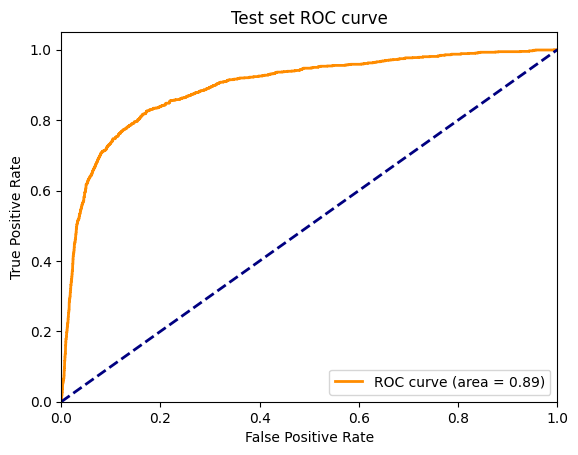

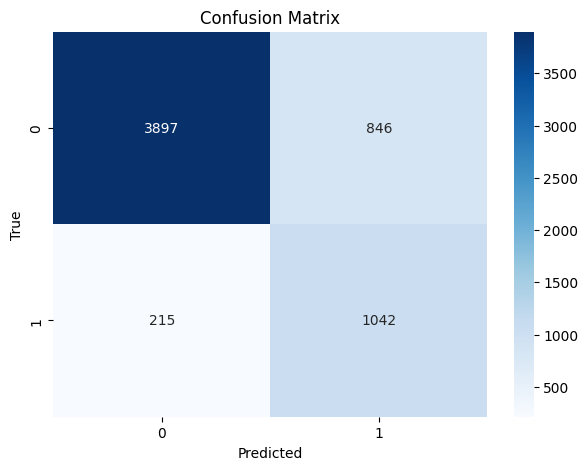

In [19]:
evaluate_network(test_dataloader, model, "Test set")

## Hyper-parameters grid search with K-fold cross validation

In [4]:
import optuna
import os
from torch.utils.data import Subset
from sklearn.model_selection import KFold
from torch.optim import SGD, Adam
from torch.nn import BCEWithLogitsLoss
from tqdm import tqdm
from torch.amp import autocast, GradScaler

def objective(trial):
    
    # hyperparameters to optimize
    hidden_size = trial.suggest_categorical("hidden_size", [8,12,16,20,24,28,32,36,40])
    num_layers = trial.suggest_categorical("num_layers",[1,2,3,4])
    learning_rate = trial.suggest_float("lr",1e-5, 1e-2,log=True)
    pos_weight = trial.suggest_float("pos_weight",1.0,pos_weight_train)

    device = "cuda" if torch.cuda.is_available() else "cpu"
    model = JetTaggerLSTM(hidden_size, num_layers).to(device)
    opt = torch.optim.Adam(model.parameters(), lr=learning_rate)

    max_epochs = 30
    patience = 10
    k=3
    kfold = KFold(n_splits=k, shuffle=True, random_state=42)


    fold_accuracies = []
    fold_aucs = []

    for fold, (train_idx, val_idx) in tqdm(enumerate(kfold.split(features)), total=k, desc=f"Trial {trial.number}"):
        # split data into training and validation
        train_subset = Subset(full_train_dataset, train_idx)
        val_subset = Subset(full_train_dataset, val_idx)
        train_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
        val_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

        # model
        model = JetTaggerLSTM(hidden_size, num_layers).to(device)
        optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)
        criterion = nn.BCEWithLogitsLoss(pos_weight=torch.tensor([pos_weight], device=device))

        best_val_loss = float('inf')
        best_val_acc = 0.0
        
        no_improve = 0

        # train with early stopping
        for epoch in range(max_epochs):
            model.train()
            for x_batch, y_batch in train_loader:
                x_batch = x_batch.to(device)
                y_batch = y_batch.unsqueeze(1).to(device)

                optimizer.zero_grad()
                y_pred = model(x_batch)
                loss = criterion(y_pred, y_batch)
                loss.backward()
                optimizer.step()

            # validate
            model.eval()
            val_preds = []
            val_trues = []
            with torch.no_grad():
                for x_batch, y_batch in val_loader:
                    x_batch = x_batch.to(device)
                    y_batch = y_batch.unsqueeze(1).to(device)
                    preds = model(x_batch)
                    val_preds.append(preds)
                    val_trues.append(y_batch)

            val_preds = torch.cat(val_preds)
            val_trues = torch.cat(val_trues)
            val_loss = criterion(val_preds, val_trues).item()
            val_acc = (torch.sigmoid(val_preds).round() == val_trues).float().mean().item()
            val_auc = roc_auc_score(val_trues, val_preds)

            if val_loss < best_val_loss - 1e-4:
                best_val_loss = val_loss
                best_val_acc = val_acc 
                best_val_auc = val_auc
                no_improve = 0
            else:
                no_improve += 1
                if no_improve >= patience:
                    break  # early stopping
        print(f"Trial {trial.number} | Fold {fold+1}: Val auc= {best_val_auc:.4f}, Val Acc= {best_val_acc:.4f}")
        
        fold_accuracies.append(best_val_acc) # store the best accuracy/auc during the training of the fold
        fold_aucs.append(best_val_auc)
        
    avg_val_acc = sum(fold_accuracies) / len(fold_accuracies)
    std_val_acc = np.std(fold_accuracies, ddof=1)
    avg_val_auc = sum(fold_aucs) /len(fold_aucs)
    std_val_auc = np.std(fold_aucs, ddof=1)
    
    print(f"Trial {trial.number} |Mean Val auc: {avg_val_auc:.4f} +- {std_val_auc:.4f}, Mean Val Accuracy: {avg_val_acc:.3f} +- {std_val_acc:.3f} | hidden size: {hidden_size}, lr: {learning_rate:.5f}, Layers: {num_layers}, pos_weight: {pos_weight:.2f}")
    # save trial weights
    os.makedirs("optuna_LSTM_models", exist_ok=True)
    trial_model_path = f"optuna_LSTM_models/23_July_trial_{trial.number}.pt"
    torch.save(model.state_dict(), trial_model_path)
    trial.set_user_attr("model_path", trial_model_path)
    trial.set_user_attr("val_accuracy", avg_val_acc)

    return avg_val_auc  # optuna will maximize this


In [ ]:
study = optuna.create_study(
    direction="maximize",
    study_name="JetTagger_LSTM_grid_search_23_July",
    storage="sqlite:///optuna_jet_tagger_LSTM_23_July.db",  # file to store the trials
    load_if_exists=True)
study.optimize(objective, n_trials=60)

In [ ]:
best_trial = study.best_trial
best_model_path = best_trial.user_attrs["model_path"]
params = best_trial.params
os.rename(best_model_path, "best_model_grid_search_23July.pt") 
print(f"Best trial #{best_trial.number} saved to best_model_grid_search_23July.pt")
print("Best hyper-parameters", params)

## Final training on the whole training set of the best model found 

In [ ]:
import torch
from torch import nn
from torch.cuda.amp import GradScaler, autocast
from torch.optim import Adam
from tqdm import tqdm
import numpy as np

# get best hyperparameters from previous grid search 
hidden_size = params["hidden_size"]
num_layers = params["num_layers"]
learning_rate = params["lr"]
pos_weight = params["pos_weight"]

model = JetTaggerLSTM(
    hidden_size=hidden_size,
    num_layers=num_layers,
    input_size=5,         
    num_classes=1         
)

device = "cuda" if torch.cuda.is_available() else "cpu"
model.to(device)


scaler = GradScaler()
opt = Adam(model.parameters(), lr=learning_rate)
loss_fn = nn.BCEWithLogitsLoss(reduction='mean',pos_weight=pos_weight_train.to(device)) 

# train on entire training set 
epochs = 50
best_auc = 0

for epoch in range(epochs):
    model.train()
    print(f"Epoch: {epoch+1}")
    iterator = tqdm(train_dataloader) 

    for batch_x, batch_y in iterator:
        batch_x = batch_x.to(device, non_blocking=True)
        batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

        opt.zero_grad()
        with autocast(enabled=False):  # True for mixed precision
            y_pred = model(batch_x)
            loss = loss_fn(y_pred, batch_y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        iterator.set_description(f"Train loss: {loss.detach().cpu().numpy()}")

    model.eval()
    with torch.no_grad():
        predictions = []
        true = []
        for batch_x, batch_y in tqdm(valid_dataloader): 
            batch_x = batch_x.to(device, non_blocking=True)
            batch_y = batch_y.unsqueeze(1).to(device, non_blocking=True)

            logits = model(batch_x)
            predictions.append(logits)
            true.append(batch_y)
        predictions = torch.cat(predictions, dim=0)
        true = torch.cat(true, dim=0)
        val_loss = loss_fn(predictions, true)
        val_acc = (torch.sigmoid(predictions).round() == true).float().mean()
        val_auc = roc_auc_score(true,predictions)
        
        print(f"Validation loss: {val_loss.item()}, auc: {val_auc.item()}, accuracy: {val_acc.item()}")

        # save model if it's the best so far
        if val_auc > best_auc:
            torch.save(model.state_dict(), "best_model_23_July_final_training.pt")
            print("saved best model")
            best_auc = val_auc


In [ ]:
# evaluation on the test set 

model = JetTaggerLSTM(
    hidden_size=params["hidden_size",
    num_layers=params["num_layers"],
    input_size=5,    
    num_classes=1)
model.load_state_dict(torch.load("best_model_23_July_final_training.pt", map_location=device))
model.to(device)
evaluate_network(test_dataloader, model, "Test set")